# 01. Import & Install Dependencies

In [12]:
%pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install tensorflow  opencv-python mediapipe scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install mediapipe

In [15]:
import cv2                                # Computer Vison Library OpenCV
import numpy as np                        # numpy arrays structure our datasets (numpy instead of tensorflow)
import os                                 # work with operating systems file path
from matplotlib import pyplot as plt      # matplotlib just helps us visualize images a little bit easier
import mediapipe as mp                    # mediapipe (https://google.github.io/mediapipe/)
from math import *

# 02. Using Mediapipe (Google's open-source framework)

In [16]:
mp_face_mesh = mp.solutions.face_mesh          # FaceMesh Model has -- 478 -- Keypoints 
mp_drawing_styles = mp.solutions.drawing_styles  # Drawing styles
mp_drawing = mp.solutions.drawing_utils            # Drawing utilites

## Given the original image and obtaining the values through the model.

In [78]:
def mediapipe_detection(image,model):                 
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)   # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                     # Image is no longer writeable
    results = model.process(image)                    # Make prediction
    image.flags.writeable = True                      # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    # COLOR CONVERSION RGB 2 BGR
    return image, results

## Storing the keypoints values in the mediapipe into a variable.

In [79]:
# face bounder indices 
FACE_OVAL=[ 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103,67, 109]
 
# Left eyes indices 
LEFT_EYE =[ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]
LEFT_EYEBROW =[ 336, 296, 334, 293, 300, 276, 283, 282, 295, 285 ]

#lips
LIPS=[ 61, 146, 91, 181, 84, 17, 314, 405, 321, 375,291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95,185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78 ]
LOWER_LIPS =[61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
UPPER_LIPS=[ 185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78] 
# right eyes indices
RIGHT_EYE=[ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]  
RIGHT_EYEBROW=[ 70, 63, 105, 66, 107, 55, 65, 52, 53, 46 ]

## Calculating blink rate (Euclidean distance).

In [80]:
# Blinking Ratio
def blinkRatio(img, landmarks, right_indices, left_indices):
    # Right eyes 
    # horizontal line 
    rh_right = landmarks[right_indices[0]]
    rh_left = landmarks[right_indices[8]]
    # vertical line 
    rv_top = landmarks[right_indices[12]]
    rv_bottom = landmarks[right_indices[4]]
    # draw lines on right eyes 
    # cv.line(img, rh_right, rh_left, utils.GREEN, 2)
    # cv.line(img, rv_top, rv_bottom, utils.WHITE, 2)

    # LEFT_EYE 
    # horizontal line 
    lh_right = landmarks[left_indices[0]]
    lh_left = landmarks[left_indices[8]]

    # vertical line 
    lv_top = landmarks[left_indices[12]]
    lv_bottom = landmarks[left_indices[4]]

    rhDistance = euclaideanDistance(rh_right, rh_left)
    rvDistance = euclaideanDistance(rv_top, rv_bottom)

    lvDistance = euclaideanDistance(lv_top, lv_bottom)
    lhDistance = euclaideanDistance(lh_right, lh_left)

    reRatio = rhDistance/rvDistance
    leRatio = lhDistance/lvDistance

    ratio = (reRatio+leRatio)/2
    return ratio

# Euclaidean distance
def euclaideanDistance(point, point1):
    x, y = point
    x1, y1 = point1
    distance = sqrt((x1 - x)**2 + (y1 - y)**2)
    if 1> distance:
        return 1
    else:
        return distance

# 03. Extract Position Landmarks (Keypoints Values) 

In [82]:
def extract_landmarks(img, results):
    resized_frame = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
    mesh_coords = mesh_coord_detection(img, results)
    
    if results.multi_face_landmarks and results.multi_face_landmarks[0]:
        # extract face 478 keypoints
        face = np.array([[res.x, res.y, res.z] for res in results.multi_face_landmarks[0].landmark]).flatten()
        
        # extract right-eye 16 keypoints
        right_eye_coords = np.array([mesh_coords[p] for p in RIGHT_EYE]).flatten()
        
        # extract left-eye 16 keypoints
        left_eye_coords = np.array([mesh_coords[p] for p in LEFT_EYE]).flatten()
        
        # calculating eye ratio
        ratio = np.array(blinkRatio(resized_frame, mesh_coords, RIGHT_EYE, LEFT_EYE)).flatten()
        
        # return all feature values 
        return np.concatenate([face, right_eye_coords, left_eye_coords, ratio])
    else:
        return np.zeros(478 * 3 + 16 * 2 * 2 + 0)
    

def mesh_coord_detection(img, results):
    img_height, img_width = img.shape[:2]
    if results.multi_face_landmarks and results.multi_face_landmarks[0]:
        # list of tuples [(x, y), (x, y), ...]
        mesh_coord = [(int(point.x * img_width), int(point.y * img_height)) for point in results.multi_face_landmarks[0].landmark]
        return mesh_coord
    else:
        return np.zeros(478 * 2)  # Return zeros for all mesh coordinates if no face landmarks detected


# 04. Setup Folder for Collection

In [83]:
DATA_PATH = os.path.join('ML_Data')         # Path for exported data, numpy arrays 
actions = np.array(['true', 'lie'])       # Actions that we try to detect
                      
true_vdos = 60                        # for taking total true videos.

lie_vdos = 61                        # for taking total lie videos.

sequence_length = 30            # Videos are going to be 30 frames in length

In [84]:
# Create Folders for save keypoints values
for action in actions:
    if action == 'true': 
        for sequence in range(true_vdos):
            try:
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            except:
                pass
    else:
        for sequence in range(lie_vdos):
            try:
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            except:
                pass

#  05. Collect Keypoints Values for Training and Testing

In [11]:
for action in actions:   # Loop through actions
    if action == 'true':
        for sequence in range(true_vdos):          # Loop through sequences (true videos)
            VDO_PATH = 'Datasets/' + action +'/' + str(sequence) + '/' + str(sequence) + '.mp4'  # /Datasets/true/0/0.mp4
            cap = cv2.VideoCapture(VDO_PATH)                # Read Video
            with mp.solutions.face_mesh.FaceMesh(                         # set mediapipe model
                max_num_faces =1,
                refine_landmarks = True,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as face_mesh:
                for frame_num in range(sequence_length):

                    ret, frame = cap.read()                                # Read feed

                    print("Processing Video Path:",VDO_PATH)                      # Processing Video Path:Datasets/true/0/0.mp4

                    image, results = mediapipe_detection(frame, face_mesh)                # Make detection

                    feature_values = extract_landmarks(image,results)                   # Extract face , left-eye , right-eye keypoints

                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num)) # create export keypoints local path

                    # Keypoints Shape:(1499,) ---> (1434 + 32 + 32 + 1)

                    np.save(npy_path, feature_values)                                   # Save Keypoints values



                cap.release()     # Release feed

                cv2.waitKey(1)    # wait for 1 Secound

                print("____________Finish__________________") 
    else:
        for sequence in range(lie_vdos):          # Loop through sequences (true videos)
            VDO_PATH = 'Datasets/' + action +'/' + str(sequence) + '/' + str(sequence) + '.mp4'  # /Datasets/lie/0/0.mp4
            cap = cv2.VideoCapture(VDO_PATH)                # Read Video
            with mp.solutions.face_mesh.FaceMesh(                         # set mediapipe model
                max_num_faces =1,
                refine_landmarks = True,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as face_mesh:
                for frame_num in range(sequence_length):

                    ret, frame = cap.read()                                # Read feed

                    print("Processing Video Path:",VDO_PATH)                      # Processing Video Path:Datasets/lie/0/0.mp4

                    image, results = mediapipe_detection(frame, face_mesh)                # Make detection

                    feature_values = extract_landmarks(image,results)                   # Extract face , left-eye , right-eye keypoints

                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num)) # create export keypoints local path

                    # Keypoints Shape:(1499,) ---> (1434 + 32 + 32 + 1)

                    np.save(npy_path, feature_values)                                   # Save Keypoints values



                cap.release()     # Release fe|ed

                cv2.waitKey(1)    # wait for 1 Secound

                print("____________Finish__________________")  

Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing

# 6. Preprocess Data and Create Labels and Features

In [85]:
from sklearn.model_selection import train_test_split # Scikit-learn for our evaluation metrics
from tensorflow.keras.utils import to_categorical   # Converting Data (Encoded)

In [86]:
label_map = {label:num for num, label in enumerate(actions)}  # Actions Label Map  {'true': 0, 'lie': 1} 

In [87]:
sequences, labels = [], []                # like : Features(X) Data , labels(Y) Data
for action in actions:              
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH,action))).astype(int):  
        values = []                       # Save all of diff.frames paricular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))  # load np array
            values.append(res)                # Append all res 
        sequences.append(values)             # Append all values
        labels.append(label_map[action])   # Append all actions on labels

In [88]:
print(len(sequences))
print(len(sequences[0]))
print(len(sequences[0][0]))

121
30
1499


In [89]:
count = 0
tot = 0
for i in range(len(sequences)):
    for j in range(30):
          tot+=1
          if len(sequences[i][j])!=1499:
            print(i,j)
            print(len(sequences[i][j]))
            count+=1
            print(count)

7 0
1498
1
7 1
1498
2
7 2
1498
3
7 3
1498
4
7 4
1498
5
7 5
1498
6
7 6
1498
7
7 7
1498
8
7 8
1498
9
7 9
1498
10
7 10
1498
11
7 11
1498
12
7 12
1498
13
7 13
1498
14
7 14
1498
15
7 15
1498
16
7 16
1498
17
7 17
1498
18
7 18
1498
19
7 19
1498
20
7 20
1498
21
7 21
1498
22
7 22
1498
23
7 23
1498
24
7 24
1498
25
7 25
1498
26
7 26
1498
27
7 27
1498
28
7 28
1498
29
7 29
1498
30
8 0
1498
31
8 1
1498
32
8 2
1498
33
8 3
1498
34
8 4
1498
35
8 5
1498
36
8 6
1498
37
8 7
1498
38
8 8
1498
39
8 9
1498
40
8 10
1498
41
8 11
1498
42
8 12
1498
43
8 13
1498
44
8 14
1498
45
8 15
1498
46
8 16
1498
47
8 17
1498
48
8 18
1498
49
8 19
1498
50
8 20
1498
51
8 21
1498
52
8 22
1498
53
8 23
1498
54
8 24
1498
55
8 25
1498
56
8 26
1498
57
8 27
1498
58
8 28
1498
59
8 29
1498
60
21 0
1498
61
21 1
1498
62
21 2
1498
63
21 3
1498
64
21 4
1498
65
21 5
1498
66
21 6
1498
67
21 7
1498
68
21 8
1498
69
21 9
1498
70
21 10
1498
71
21 11
1498
72
21 12
1498
73
21 13
1498
74
21 14
1498
75
21 15
1498
76
21 16
1498
77
21 17
1498
78
21 18
1

In [90]:
print(len(sequences[3][0]))
sequences[3][0]=sequences[3][0][:-1]
print(len(sequences[3][0]))

1499
1498


In [91]:
import numpy as np

# Assuming sequences is a list of lists

# Calculate mean of non-missing values in all sequences
non_missing_values = [value for sequence in sequences for sublist in sequence for value in sublist if len(sublist) == 1499]
mean_value = np.mean(non_missing_values)

for i in range(len(sequences)):
    for j in range(30):
        if len(sequences[i][j]) != 1499:
            sequences[i][j]([mean_value])


TypeError: 'numpy.ndarray' object is not callable

In [92]:
for i in range(len(sequences)):
    for j in range(30):
          if len(sequences[i][j])==1499:
              sequences[i][j]  = sequences[i][j][:-1]

#test split

In [93]:
X = np.asarray(sequences)  # sequences
y = to_categorical(labels).astype(int)  # labels
# Train & Testing Partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [94]:
len(X_train)

114

In [95]:
# X.shape : (42, 30, 1499)  -----> ( Sequences(videos) , framers per vdo, keypoints shape [(478 * 3) + (32 * 2) + 1] )
# y.shape : (42, 2) -------->   ( Sequences(videos), labels[actions] )

# X_train.shape : (39, 30, 1499) 
# X_test.shape : (3, 30, 1499)

# y_train.shape : (39, 2) 
# y_test.shape : (3, 2) 

In [96]:
len(X)

121

In [97]:
y.shape

(121, 2)

In [98]:
len(X_train)

114

In [99]:
len(X_test)

7

In [100]:
y_train.shape

(114, 2)

In [101]:
y_test.shape

(7, 2)

# 7. Build and Train LSTM Neural Network

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [103]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [127]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1498)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [128]:
actions.shape[0]

2

In [129]:
res = [.7, 0.2, 0.1]

In [130]:
actions[np.argmax(res)]

'true'

In [131]:
model.compile(optimizer='Adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [132]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - categorical_accuracy: 0.5480 - loss: 268.1096
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.4372 - loss: 299.6568
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.4791 - loss: 231.6396
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.5133 - loss: 166.9536
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.3920 - loss: 303.3308
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5432 - loss: 129.7691
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.4835 - loss: 107.0610
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.5220 - loss: 93.8565
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.5552 - loss: 149.0636
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.4546 - loss: 134.4655
Epoch 11/100
4/4 ━━━

In [133]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │       400,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,318 (4.23 MB)

 Trainable params: 554,658 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 554,660 (2.12 MB)

# 8. Make Predictions

In [134]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


In [135]:
res

array([[0.0000000e+00, 1.0000000e+00],
       [9.9996936e-01, 3.0611038e-05],
       [5.1515162e-01, 4.8484841e-01],
       [1.0000000e+00, 3.4016716e-21],
       [5.1515162e-01, 4.8484841e-01],
       [1.0000000e+00, 0.0000000e+00],
       [9.9192214e-01, 8.0779083e-03]], dtype=float32)

In [136]:
np.sum(res[0])

1.0

In [137]:
actions[np.argmax(res[0])]

'lie'

In [138]:
y_test

array([[0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1]])

In [139]:
actions[np.argmax(y_test[0])]

'lie'

# 9. Save Weights

In [140]:
model.save('action.keras')

In [ ]:
del model

In [141]:
model.load_weights('action.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [142]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [143]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [144]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [145]:
plt.figure(figsize=(18,18))

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [146]:
ytrue

[1, 1, 1, 0, 0, 1, 1]

In [147]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 4],
        [0, 2]],

       [[2, 0],
        [4, 1]]], dtype=int64)

In [148]:
multilabel_confusion_matrix

<function sklearn.metrics._classification.multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)>

In [149]:
accuracy_score(ytrue, yhat)

0.42857142857142855

In [150]:
%pip install tensorflow.keras.wrappers

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow.keras.wrappers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.wrappers


In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score , confusion_matrix
import itertools
import numpy as np

In [155]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=42)

# Define a function to create your LSTM model
def create_model(units, activation, optimizer):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, activation=activation, input_shape=(30, 1498)))
    model.add(LSTM(128, return_sequences=True, activation="tanh"))
    model.add(LSTM(64, return_sequences=False, activation="relu"))
    model.add(Dense(64, activation=activation))
    model.add(Dense(actions.shape[0], activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

# Define hyperparameter combinations
units_values = [32, 64, 128]
activation_values = ['relu', 'tanh']
optimizer_values = ['adam', 'rmsprop']

best_accuracy = 0.0
best_precision = 0.0
best_recall = 0.0
best_params = {}

# Iterate through all combinations
for units, activation, optimizer in itertools.product(units_values, activation_values, optimizer_values):
    model = create_model(units=units, activation=activation, optimizer=optimizer)
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate on the validation set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    confusion_mat = confusion_matrix(y_test_classes, y_pred_classes)
    
    # Update the best parameters if accuracy, precision, and recall improve
    if accuracy > best_accuracy and precision > best_precision and recall > best_recall:
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_params = {'units': units, 'activation': activation, 'optimizer': optimizer}
        best_confusion_matrix = confusion_mat
        model.save('best_model.keras')
# Print the best parameters, accuracy, precision, and recall
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)
print("Best Precision: ", best_precision)
print("Best Recall: ", best_recall) 

  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

  super().__init__(**kwargs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Parameters:  {'units': 32, 'activation': 'relu', 'optimizer': 'rmsprop'}
Best Accuracy:  1.0
Best Precision:  1.0
Best Recall:  1.0


# 11. Test in Real Time

In [156]:
import csv

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Define a function to create your LSTM model
def create_model(units, activation, optimizer):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, activation=activation, input_shape=(30, 1498)))
    model.add(LSTM(units, return_sequences=True, activation="tanh"))
    model.add(LSTM(units, return_sequences=False, activation="relu"))
    model.add(Dense(units, activation=activation))
    model.add(Dense(actions.shape[0], activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a function to create your 2D CNN model
def create_2d_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(30, 1498, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [95]:

# Define a function to create your 3D CNN model
def create_3d_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(30, 1498, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [318]:
def train_model(X_train, y_train, X_test, y_test, units, activation, optimizer):
    model = create_model(units=units, activation=activation, optimizer=optimizer)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate on the validation set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    
    return accuracy, precision, recall, history, model

In [319]:

# Define hyperparameter combinations
units_values = [32, 64, 128]
activation_values = ['relu', 'tanh']
optimizer_values = ['adam', 'rmsprop']
# Define the CSV filename
csv_filename = "all_model_performances.csv"

# Open the CSV file for writing
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(["Units", "Activation", "Optimizer", "Accuracy", "Precision", "Recall"])
    
    # Iterate through all combinations
    for units, activation, optimizer in itertools.product(units_values, activation_values, optimizer_values):
        # Train the model and evaluate performance
        accuracy, precision, recall, _, _ = train_model(X_train, y_train, X_test, y_test, units, activation, optimizer)
        
        # Write the results to the CSV file
        writer.writerow([units, activation, optimizer, accuracy, precision, recall])

  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


In [320]:
import matplotlib.pyplot as plt

# Define function to create and train the model
def train_model(X_train, y_train, X_test, y_test, units, activation, optimizer):
    model = create_model(units=units, activation=activation, optimizer=optimizer)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate on the validation set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    
    return accuracy, precision, recall, history, model

# Initialize variables to keep track of the best performance
best_accuracy = 0.0
best_precision = 0.0
best_recall = 0.0
best_params = {}
best_model = None
best_history = None

# Iterate through all combinations
for units, activation, optimizer in itertools.product(units_values, activation_values, optimizer_values):
    accuracy, precision, recall, history, model = train_model(X_train, y_train, X_test, y_test, units, activation, optimizer)
    
    # Update the best parameters if accuracy, precision, and recall improve
    if accuracy > best_accuracy and precision > best_precision and recall > best_recall:
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_params = {'units': units, 'activation': activation, 'optimizer': optimizer}
        best_model = model
        best_history = history

# Print the best parameters, accuracy, precision, and recall
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)
print("Best Precision: ", best_precision)
print("Best Recall: ", best_recall)

# Plot accuracy and loss curves for the best model


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step


  super().__init__(**kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
Best Parameters:  {'units': 32, 'activation': 'relu', 'optimizer': 'adam'}
Best Accuracy:  0.5405405405405406
Best Precision:  0.5623700623700624
Best Recall:  0.5405405405405406


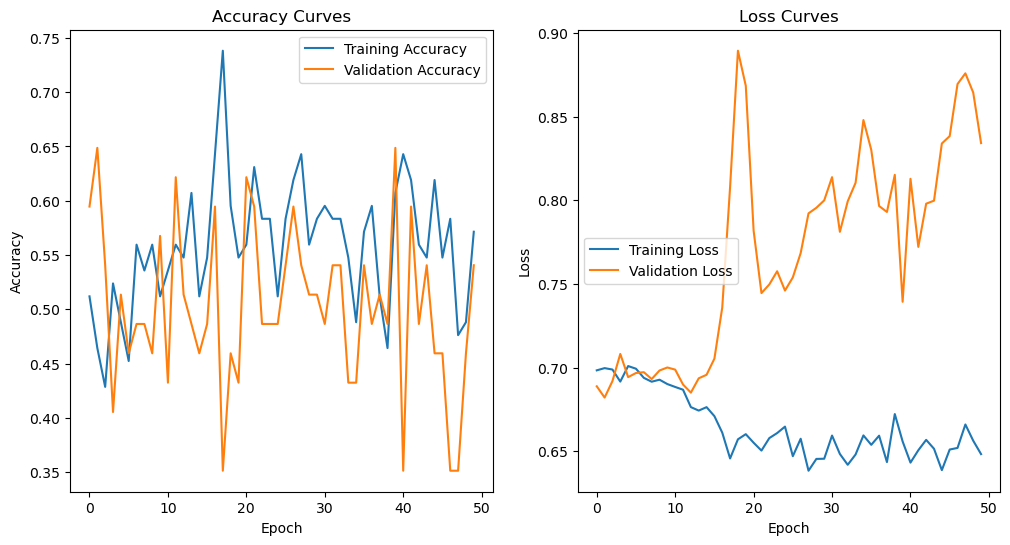

In [321]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 


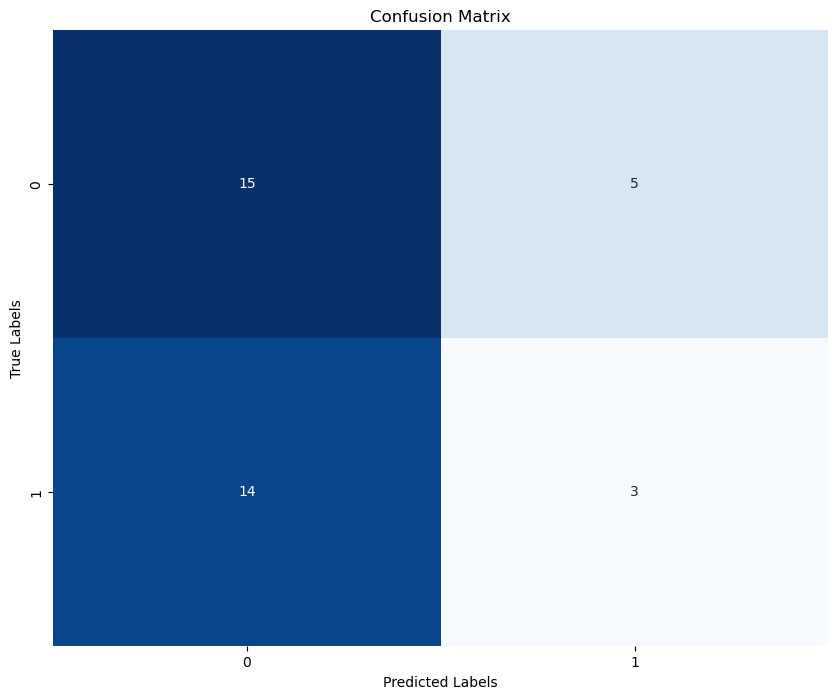

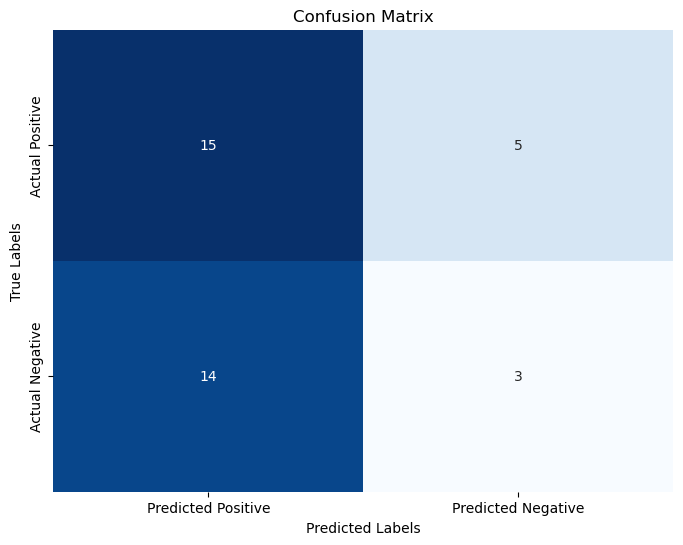

In [160]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Predict labels for the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)


# Add labels for clarity
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Positive', 'Predicted Negative'])
plt.yticks(ticks=[0.5, 1.5], labels=['Actual Positive', 'Actual Negative'])

plt.show()


In [21]:
import tensorflow as tf

In [22]:
model = tf.keras.models.load_model(r'C:\Users\OM USKAIKAR\Downloads\LieDetection\Semester Research Program\best_model.keras')

In [23]:
colors = [(0, 176, 240), (255, 255, 0), (0, 255, 0)]  # Blue, Yellow, Green

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
    return output_frame

In [24]:
def draw_landmarks(image,face_landmarks):
    # Draw face connections
    mp_drawing.draw_landmarks(
            image= image,
            landmark_list= face_landmarks,
            connections= mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec= None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
    
    # Draw face countours (FACEMESH_CONTOURS = frozenset().union(*[FACEMESH_LIPS, FACEMESH_LEFT_EYE, FACEMESH_LEFT_EYEBROW, FACEME) connections
    mp_drawing.draw_landmarks(
            image= image,
            landmark_list= face_landmarks,
            connections= mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec= None,
            connection_drawing_spec= mp_drawing_styles.get_default_face_mesh_contours_style())
    
    # Draw eye iris ( FACEMESH_IRISES = frozenset().union(*[FACEMESH_LEFT_IRIS, FACEMESH_RIGHT_IRIS]) ) connections
    mp_drawing.draw_landmarks(
            image= image,
            landmark_list= face_landmarks,
            connections= mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec= None,
            connection_drawing_spec= mp_drawing_styles.get_default_face_mesh_iris_connections_style())

#Testing

In [28]:
import cv2
import numpy as np
import mediapipe as mp

# Function for visualization of probabilities
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num].capitalize() + ' ' + str(int(prob * 100)) + ' %',
                    (3, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (116,238,21), 2, cv2.LINE_AA)
    return output_frame

# New detection variables
sequence = []
# Load video
cap = cv2.VideoCapture('C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/lie/1/1.mp4')

# Set up MediaPipe FaceMesh
with mp.solutions.face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,
                                      min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, face_mesh)
        print(results)

        # Prediction Logic
        keypoints = extract_landmarks(image, results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            for i in range(30):
                if len(sequence[i]) == 1499:
                    sequence[i]=sequence[i][:-1]
            print(len(sequence[0]))
            print(np.array(sequence).shape)
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            # if (max(res)>0.53):
            #      print(actions[np.argmax(res)])
            # else: 
            #     print("low confidence")
            print(actions[np.argmax(res)])
            # Visualization of probabilities
            image = prob_viz(res, actions, image, colors)
        # Show on screen
        cv2.imshow('Lie Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [29]:
model.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                 │ (None, 30, 32)         │       195,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_121 (LSTM)                 │ (None, 30, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,296 (3.80 MB)

 Trainable params: 332,098 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 664,198 (2.53 MB)

In [30]:
import cv2
import numpy as np
import mediapipe as mp

def perform_lie_detection(video_path, output_path='output_video.mp4'):
    # Function for visualization of probabilities
    def prob_viz(res, actions, input_frame, colors):
        output_frame = input_frame.copy()
        for num, prob in enumerate(res):
            cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
            cv2.putText(output_frame, actions[num].capitalize() + ' ' + str(int(prob * 100)) + ' %',
                        (3, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (116, 238, 21), 2, cv2.LINE_AA)
        return output_frame

    # New detection variables
    sequence = []

    # Set up MediaPipe FaceMesh
    with mp.solutions.face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,
                                          min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:

        cap = cv2.VideoCapture(video_path)

        # Get video information
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Define codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        while cap.isOpened():
            # Read feed
            ret, frame = cap.read()
            if not ret:
                break

            # Make detections
            image, results = mediapipe_detection(frame, face_mesh)
            print(results)

            # Prediction Logic
            keypoints = extract_landmarks(image, results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            if len(sequence) == 30:
                for i in range(30):
                    if len(sequence[i]) == 1499:
                        sequence[i] = sequence[i][:-1]
                print(len(sequence[0]))
                print(np.array(sequence).shape)
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])

                # Visualization of probabilities
                image = prob_viz(res, actions, image, colors)

            # Write frame to output video
            out.write(image)

            # Show on screen
            cv2.imshow('Lie Detection', image)

            # Break gracefully
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        out.release()
        cv2.destroyAllWindows()

# Example usage
perform_lie_detection(r'C:\Users\OM USKAIKAR\Downloads\LieDetection\Semester Research Program\Datasets\lie\23\23.mp4', 'output_video.mp4')


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [31]:
import cv2
import numpy as np
import mediapipe as mp

# Function for visualization of probabilities
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num].capitalize() + ' ' + str(int(prob * 100)) + ' %',
                    (3, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (116,238,21), 2, cv2.LINE_AA)
    return output_frame

# New detection variables
sequence = []
overall_results = []

# Load video
cap = cv2.VideoCapture('C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/lie/1/1.mp4')

# Set up MediaPipe FaceMesh
with mp.solutions.face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,
                                      min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, face_mesh)
        print(results)

        # Prediction Logic
        keypoints = extract_landmarks(image, results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            for i in range(30):
                if len(sequence[i]) == 1499:
                    sequence[i]=sequence[i][:-1]
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            overall_results.append(res)  # Accumulate the results for each frame
            # Visualization of probabilities
            image = prob_viz(res, actions, image, colors)
        
        # Show on screen
        cv2.imshow('Lie Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Calculate overall result
overall_results = np.array(overall_results)
average_result = np.mean(overall_results, axis=0)
print("Overall Result:", actions[np.argmax(average_result)]) 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [47]:
%pip install librosa moviepy

Note: you may need to restart the kernel to use updated packages.


In [55]:
%pip install tensorflow==2.16.1

  You can safely remove it manually.
  You can safely remove it manually.



  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/377.0 MB 9.6 MB/s eta 0:00:40
   ---------------------------------------- 0.6/377.0 MB 8.0 MB/s eta 0:00:47
   ---------------------------------------- 0.9/377.0 MB 7.0 MB/s eta 0:00:54
   ---------------------------------------- 1.1/377.0 MB 6.5 MB/s eta 0:00:58
   ---------------------------------------- 1.3/377.0 MB 5.9 MB/s eta 0:01:04
   ---------------------------------------- 1.5/377.0 MB 5.5 MB/s eta 0:01:09
   ---------------------------------------- 1.6/377.0 MB 5.3 MB/s eta 0:01:12
   ---------------------------------------- 1.8/377.0 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 2.0/377.0 MB 4.9 MB/s eta 0:01:18
   --

In [4]:
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow version: {librosa.__version__}")


TensorFlow version: 2.16.1
TensorFlow version: 0.10.1


In [66]:
import librosa
import numpy as np
import tensorflow as tf

from moviepy.editor import VideoFileClip

def extract_audio_from_video(video_path, output_audio_path):
    video = VideoFileClip(video_path)
    video.audio.write_audiofile(output_audio_path)

video_path = 'C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/lie/11/11.mp4'
output_audio_path = 'C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/lie/11/11.wav'
extract_audio_from_video(video_path, output_audio_path)

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

def classify_audio(model, file_path):
    features = extract_features(file_path)
    features = features.reshape(1, features.shape[0], 1)
    prediction = model.predict(features)
    return prediction

# Load the saved model
# loaded_model = tf.keras.models.load_model(r"C:\Users\Aditya\Downloads\FINAL_IPD_PROJ\deception_detection_model_Final.h5")
loaded_model = tf.keras.models.load_model(r"C:\Users\OM USKAIKAR\Downloads\LieDetection\Semester Research Program\deception_detection_model_12326.h5")



# Determine file extension
if output_audio_path.lower().endswith('.mp3'):
    audio_format = 'mp3'
elif output_audio_path.lower().endswith('.wav'):
    audio_format = 'wav'
else:
    raise ValueError("Unsupported audio format. Only .mp3 and .wav files are supported.")

# Make prediction
prediction = classify_audio(loaded_model,output_audio_path)
print(prediction)

# Assuming the model predicts 1 for deceptive and 0 for truthful
if prediction >= 0.5:
    print("Prediction: Deceptive")
else:

    print("Prediction: Truthful")

MoviePy - Writing audio in C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/lie/11/11.wav


MoviePy - Done.


(1, 40, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
[[0.99999964]]
Prediction: Deceptive


In [35]:
def harmonic_mean_elementwise(a, b):
    if len(a) != len(b):
        raise ValueError("Lists must be of equal length")
    harmonic_means = []
    for i in range(len(a)):
        if a[i] == 0 or b[i] == 0:
            harmonic_means.append(0)
        else:
            harmonic_means.append(2 / ((1 / a[i]) + (1 / b[i])))

    return harmonic_means
def arithmetic_mean_elementwise(a, b):
    if len(a) != len(b):
        raise ValueError("Lists must be of equal length")
    arithmetic_means = []
    for i in range(len(a)):
        arithmetic_means.append((a[i] + b[i]) / 2)
    return arithmetic_means

def geometric_mean_elementwise(a, b):
    if len(a) != len(b):
        raise ValueError("Lists must be of equal length")
    geometric_means = []
    for i in range(len(a)):
        geometric_means.append((a[i] * b[i]) ** 0.5)
    return geometric_means

def quadratic_mean_elementwise(a, b):
    if len(a) != len(b):
        raise ValueError("Lists must be of equal length")
    quadratic_means = []
    for i in range(len(a)):
        quadratic_means.append(((a[i] ** 2) + (b[i] ** 2)) ** 0.5 / 2)
    return quadratic_means


In [199]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd

# Function for visualization of probabilities
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num].capitalize() + ' ' + str(int(prob * 100)) + ' %',
                    (3, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (116,238,21), 2, cv2.LINE_AA)
    return output_frame

# New detection variables
sequence = []
overall_results = []
video_path = 'C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/true/141/141.mp4'
output_audio_path = video_path.replace(".mp4", ".wav")
extract_audio_from_video(video_path, output_audio_path)
# Load video
cap = cv2.VideoCapture(video_path)

# Set up MediaPipe FaceMesh
with mp.solutions.face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,
                                      min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    t0 = time.time()
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, face_mesh)
        print(results)

        # Prediction Logic
        keypoints = extract_landmarks(image, results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            for i in range(30):
                if len(sequence[i]) == 1499:
                    sequence[i]=sequence[i][:-1]
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            overall_results.append(res)  # Accumulate the results for each frame
            # Visualization of probabilities
            image = prob_viz(res, actions, image, colors)
        
        # Show on screen
        cv2.imshow('Lie Detection', image)
        t1 = time.time() 
        num_seconds = t1 - t0 # diff
        if num_seconds > 10:  # e.g. break after 30 seconds
            break
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Calculate overall result
overall_results = np.array(overall_results)
average_result = np.mean(overall_results, axis=0)


prediction = classify_audio(loaded_model,output_audio_path)


# Assuming the model predicts 1 for deceptive and 0 for truthful
if output_audio_path.lower().endswith('.mp3'):
    audio_format = 'mp3'
elif output_audio_path.lower().endswith('.wav'):
    audio_format = 'wav'
else:
    raise ValueError("Unsupported audio format. Only .mp3 and .wav files are supported.")
if prediction >= 0.5:
    NewValue = (((prediction[0] - 0.5) * (1 - 0)) / (1 - 0.5)) + 0
    prediction = [1-NewValue,NewValue]
else:
    NewValue = (((prediction[0] - 0.5) * (1 - 0)) / (0 - 0.5)) + 0
    prediction = [NewValue,1-NewValue]



arithmetic_means = arithmetic_mean_elementwise(prediction, average_result)
geometric_means = geometric_mean_elementwise(prediction, average_result)
quadratic_means = quadratic_mean_elementwise(prediction, average_result)
harmonic_means = harmonic_mean_elementwise(prediction, average_result)
# Define the means and their names
mean_types = ["Audio","Video","Arithmetic Mean", "Geometric Mean", "Quadratic Mean", "Harmonic Mean"]
means = [prediction,average_result,arithmetic_means, geometric_means, quadratic_means, harmonic_means]

# Create a DataFrame
df = pd.DataFrame({"Mean Type": mean_types, "Result": means})
# Print the DataFrame
print(df)


print("Overall Result:", actions[np.argmax(harmonic_means)]) 


MoviePy - Writing audio in C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/true/141/141.wav


MoviePy - Done.
<class 'mediapipe.python.solution_base.SolutionOutputs'>


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [49]:
model.summary()
loaded_model.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                 │ (None, 30, 32)         │       195,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_121 (LSTM)                 │ (None, 30, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,296 (3.80 MB)

 Trainable params: 332,098 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 664,198 (2.53 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 17, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,619 (1.10 MB)

 Trainable params: 287,617 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Final Function

In [296]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd

def process_video(video_path):
    def prob_viz(res, actions, input_frame, colors):
        output_frame = input_frame.copy()
        for num, prob in enumerate(res):
            cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
            cv2.putText(output_frame, actions[num].capitalize() + ' ' + str(int(prob * 100)) + ' %',
                        (3, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (116,238,21), 2, cv2.LINE_AA)
        return output_frame

    sequence = []
    overall_results = []

    # Load video
    cap = cv2.VideoCapture(video_path)

    # Set up MediaPipe FaceMesh
    with mp.solutions.face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,
                                          min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        t0 = time.time()
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            image, results = mediapipe_detection(frame, face_mesh)  # You need to implement mediapipe_detection function
            print(results)

            keypoints = extract_landmarks(image, results)  # You need to implement extract_landmarks function
            sequence.append(keypoints)
            sequence = sequence[-30:]
            if len(sequence) == 30:
                for i in range(30):
                    if len(sequence[i]) == 1499:
                        sequence[i] = sequence[i][:-1]
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                overall_results.append(res)
                image = prob_viz(res, actions, image, colors)  # You need to define actions and colors

            cv2.imshow('Lie Detection', image)
            t1 = time.time()
            if t1-t0 >15 :
                break
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    overall_results = np.array(overall_results)
    average_result = np.mean(overall_results, axis=0)

    prediction = classify_audio(loaded_model, output_audio_path)  # You need to define loaded_model and classify_audio function

    if output_audio_path.lower().endswith('.mp3'):
        audio_format = 'mp3'
    elif output_audio_path.lower().endswith('.wav'):
        audio_format = 'wav'
    else:
        raise ValueError("Unsupported audio format. Only .mp3 and .wav files are supported.")
    
    if prediction >= 0.5:
        NewValue = (((prediction[0] - 0.5) * (1 - 0)) / (1 - 0.5)) + 0
        prediction = [1-NewValue, NewValue]
    else:
        NewValue = (((prediction[0] - 0.5) * (1 - 0)) / (0 - 0.5)) + 0
        prediction = [NewValue, 1-NewValue]

    arithmetic_means = arithmetic_mean_elementwise(prediction, average_result)  # You need to define arithmetic_mean_elementwise
    geometric_means = geometric_mean_elementwise(prediction, average_result)  # You need to define geometric_mean_elementwise
    quadratic_means = quadratic_mean_elementwise(prediction, average_result)  # You need to define quadratic_mean_elementwise
    harmonic_means = harmonic_mean_elementwise(prediction, average_result)  # You need to define harmonic_mean_elementwise
    
    mean_types = ["Audio", "Video", "Arithmetic Mean", "Geometric Mean", "Quadratic Mean", "Harmonic Mean"]
    means = [prediction, average_result, arithmetic_means, geometric_means, quadratic_means, harmonic_means]

    df = pd.DataFrame({"Mean Type": mean_types, "Result": means})
    print(df)

    return actions[np.argmax(arithmetic_means)]

# Call the function with the video path
video_path = 'C:/Users/OM USKAIKAR/Downloads/LieDetection/Semester Research Program/Datasets1/true/141/141.mp4'
result = process_video(video_path)
print("Overall Result:", result)


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [297]:
import os
import pandas as pd

def find_mp4_files(directory):
    mp4_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".mp4"):
                mp4_files.append(os.path.join(root, file))
    return mp4_files

directory = r"C:\Users\OM USKAIKAR\Downloads\LieDetection\Semester Research Program\Datasets1"
mp4_paths = find_mp4_files(directory)

# Create a DataFrame to store the paths
df = pd.DataFrame(mp4_paths, columns=["File Path"])

# Display the DataFrame
df


,File Path
0,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
1,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
2,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
3,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
4,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
...,...
167,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
168,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
169,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
170,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...


In [305]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Display the shapes of train and test sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (120, 1)
Test set shape: (52, 1)


In [306]:
test_df

,File Path
76,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
138,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
152,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
60,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
156,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
165,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
85,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
142,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
114,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...
31,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...


In [307]:
import pandas as pd
import re

def check_word_in_path(path):
    if re.search(r'true', path, re.IGNORECASE):
        return 'true'
    elif re.search(r'lie', path, re.IGNORECASE):
        return 'lie'
    else:
        return 'unknown'  # or any other value you want for cases where neither 'true' nor 'lie' is found

# Apply the function to each file path and add the result to a new column
test_df['Expected'] = test_df['File Path'].apply(check_word_in_path)

test_df

,File Path,Expected
76,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
138,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
152,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
60,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
156,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
165,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
85,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
142,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
114,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true
31,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true


In [308]:
test_df['Result'] = test_df['File Path'].apply(process_video)

# Print the updated DataFrame with the 'Result' column
print(test_df)

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [309]:
test_df

,File Path,Expected,Result
76,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
138,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
152,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
60,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
156,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
165,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
85,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
142,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
114,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true
31,C:\Users\OM USKAIKAR\Downloads\LieDetection\Se...,true,true


In [316]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate accuracy
correct_predictions = (test_df['Result'] == test_df['Expected']).sum()
total_predictions = len(test_df)
accuracy = correct_predictions / total_predictions * 100
print("Accuracy:", accuracy, "%")

# Calculate precision
precision = precision_score(test_df['Expected'], test_df['Result'], pos_label='lie')

# Calculate recall
recall = recall_score(test_df['Expected'], test_df['Result'], pos_label='lie')

# Calculate F1 score
f1 = f1_score(test_df['Expected'], test_df['Result'], pos_label='lie')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 94.23076923076923 %
Precision: 0.5
Recall: 0.3333333333333333
F1 Score: 0.4


In [311]:
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_df['Expected'], test_df['Result'])
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 1  2]
 [ 1 48]]
